# Recurrent Neural Network
***
**Name**: Nicholas Renninger
***

## Goal
The goal of this assignment is to use TensorFlow to build some recurrent neural nets (RNNs) and to understand their limitations through experimentation.

## The Task
You will implement a recurrent neural net to learn the parity operator. The net will have a single input unit and a single output unit, and a fully-connected layer of H hidden units. The inputs and target outputs are binary. When an input sequence is presented, the output state at the end of the sequence should be a parity bit: output should be 1 if the input has an odd number of '1' values. For example, the sequence 1-0-0-1-0-1 should yield output 1 and the sequence 0-0-0-0-1-1 should yield output 0. Note that a target is given only at the end of each sequence. (Parity is easy to learn if there is a target at each step that indicates parity given the sequence so far.)

Parity is a hard problem for neural nets to learn because very similar inputs produce different outputs, and very dissimilar inputs can produce the same output.

The aspects of the task we will manipulate are:  H, the number of hidden units, N, the length of the input strings, and the activation function for the hidden units, either tanh or LSTM-style neurons. The output neuron should have a logistic activation function.

Tip: get started early.  Depending on your system, these nets can take several minutes to train.  Exploring hyperparameters (such as training rate) will be critical for success.


### Some Help
Below are some helper codes to:
- generate input strings and their parity.
- provide a callback to trigger early stopping during training
- plotting

In [101]:
# %tensorflow_version 2.x # use only in Google Colab
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


def gen_binary_sequences(num, length):
    '''
    Generate :num: sequences of length :length:.
    '''
    return(np.random.randint(0, 2, size=(num, length), dtype=np.int32))

def calc_parity(seqs):
    '''
    Calculate sequence parity (1 if odd number of 1s, 0 if even number of 1s)
    '''
    return(seqs.sum(axis=-1) % 2)


class create_accuracy_callback(tf.keras.callbacks.Callback):
    '''
    Callback function to stop training at 100% accuracy
    '''
    def on_epoch_end(self, epoch, logs={}):

        if(logs['accuracy'] == 1.0 and logs['val_accuracy'] == 1.0):
            self.model.stop_training = True


def plot_accuracies(accuracies,Ns,Hs):
    '''
    Make a graph of mean % correct (and standard error) on the test set for the
    different values of H and N.

    Input: ndarray of |Hs|x|Ns|x(reps)
         actual values of Ns and Hs
    '''
    
    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]
    
    lenH,lenN,lenreps = accuracies.shape
    assert(lenH == len(Hs))
    assert(lenN == len(Ns))
    
    accuracies_mean = accuracies.mean(axis=2)
    accuracies_std = accuracies.std(axis=2)
    accuracies_stderr = accuracies_std/np.sqrt(lenreps)

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axhline(0.5,linestyle="--",color="gray") # chance baseline
    centers = np.arange(lenN)

    for Hindex, H in enumerate(Hs):
        ax.bar(centers + 0.8/lenH*(Hindex-(lenH-1)/2),
               accuracies_mean[Hindex], 0.8/lenH,
               yerr=accuracies_stderr[Hindex],
               alpha=0.5, label=f"{H} hidden units")

    ax.set_xlabel("sequence length")
    plt.xticks(centers,Ns)
    ax.set_ylabel("accuracy")
    plt.legend(loc="lower left")

## Part 1

Experiments with vanilla RNNs $\textrm{tanh}$ activations.

### Part 1.a
Fill in the code to create a net given H and N using the tanh activation function for the hidden units.  Keras has a number of RNN helper functions, although you can also write your own custom layers.

Remember that the net should only take one bit of input at a time from the input sequence, and output one logistic value (between 0 and 1) only after the input sequence is complete.

In [49]:
def build_tanh_model(N, H):
    '''
    Builder for an RNN model with tanh hidden activations.
    Model inputs are binary sequences of length :N:.

    At each sequence position, the input and prior state should be fully
    connected to :H: hidden units with tanh activation.

    The output of the last state of the RNN should be fully connected to a 
    single unit with logistic activation, to perform the final 
    classification of the sequence.
    '''
    # %%% TO DO %%%
    model = None

    return model

### Part 1.b
Then fill in the code to train several such nets.  Each repetition should randomize the initial weights and generate a random training set of 10000 examples of length N as well as a random test set of 10000 examples of length N.  Save 10% of the training as validation, and use at least the provided check_accuracy callback as an early stopping condition.

Train nets for H ∈ {5, 25} and for N ∈ {5, 10, 15, 20}.  For each combination of H and N, run 10 replications of your simulation.  You will also need to try to find helpful learning rates; don't be surprised if your training is prone to cycles of stagnation for hundreds of epochs before quickly learning.

In [89]:
def train_model(model, x_train, y_train, batch_size, epochs, x_test, y_test,
                early_termination_callback):
    '''
    Compiles and trains the :model:.
    
    return:
    
    test_accuracy (float): a list the length of epochs that contains the
                           model's val_acc metric during each epoch of training
    '''
    # start by compiling the model; accuracy should be a tracked metric
    # %%% TO DO %%%

    # train model
    # %%% TO DO %%%
    acc = np.random.normal(0.0, 1.0)
    return acc

Now, we need to define a function to take all of our model / training parameter exploration ranges and:

* perform multiple experiments per parameter combination
* train the desired RNN model using different combination parameters for each experiment 
* collect and return the test set accuracy the model using each set of parameter pairs for each experiment

In [104]:
def study_rnn_performance(model_builder, Hs, Ns, early_termination_callback,
                          REPS=10, SAMPLES=10000, BATCH=1000, MAX_EPOCHS=2000):

    test_accs = np.zeros([len(Hs), len(Ns), REPS])

    for Nindex, N in enumerate(Ns):
        print('')
        for rep in range(REPS):

            # (data is reusable across changes to the number of hidden units)
            # generate a random training set of SAMPLES examples of length N
            x = gen_binary_sequences(num=SAMPLES, length=int(2 * N))
            y = calc_parity(x)
            x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                                test_size=N)

            for Hindex, H in enumerate(Hs):
                print(f"starting N={N}, H={H}, rep {rep + 1} / {REPS}")

                model = model_builder(N, H)
                test_acc = train_model(model, x_train, y_train,
                    batch_size=BATCH,
                    epochs=MAX_EPOCHS,
                    x_test=x_test,
                    y_test=y_test,
                    early_termination_callback=early_termination_callback)

                # save for plotting later
                test_accs[Hindex, Nindex, rep] = test_acc
                
    return test_accs

For this part, we will explore a range of sequence lengths and number of hidden units in an using tanh hidden layer activations RNN:

In [108]:
Hs = [5, 25]
Ns = [5] # switch to [5, 10, 20, 40] when things are working
check_accuracy = create_accuracy_callback()

test_accs = study_rnn_performance(build_tanh_model, Hs, Ns,
                                  early_termination_callback=check_accuracy)


starting N=5, H=5, rep 1 / 10
starting N=5, H=25, rep 1 / 10
starting N=5, H=5, rep 2 / 10
starting N=5, H=25, rep 2 / 10
starting N=5, H=5, rep 3 / 10
starting N=5, H=25, rep 3 / 10
starting N=5, H=5, rep 4 / 10
starting N=5, H=25, rep 4 / 10
starting N=5, H=5, rep 5 / 10
starting N=5, H=25, rep 5 / 10
starting N=5, H=5, rep 6 / 10
starting N=5, H=25, rep 6 / 10
starting N=5, H=5, rep 7 / 10
starting N=5, H=25, rep 7 / 10
starting N=5, H=5, rep 8 / 10
starting N=5, H=25, rep 8 / 10
starting N=5, H=5, rep 9 / 10
starting N=5, H=25, rep 9 / 10
starting N=5, H=5, rep 10 / 10
starting N=5, H=25, rep 10 / 10


**Part 1.c**<br>
Make the graph of mean % correct (and standard error) on the test set for the different values of H and N.

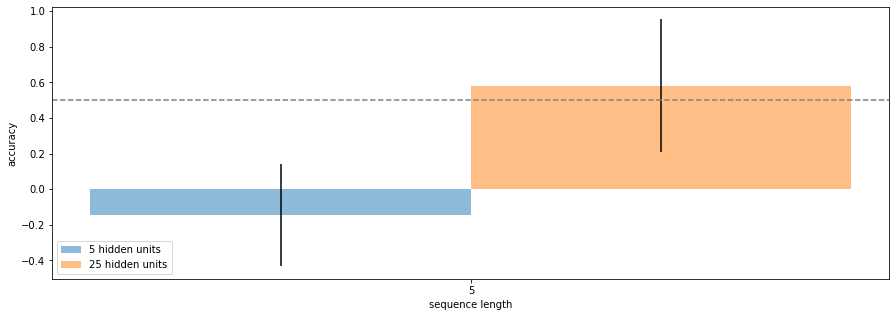

In [109]:
plot_accuracies(test_accs, Ns, Hs)

## Part 2
Repeat the experiments of Part 1, but use LSTM neurons instead of tanh neurons in the recurrent layer.  Comment on your experiences.